In [1]:
import ROOT as R
from array import array
R.gROOT.SetBatch(True)

Welcome to JupyROOT 6.28/00


In [2]:
# Global variables
SIGNAL = "MHc-160_MA-85"
ERA = "2018"
CHANNEL = "Skim3Mu"
NETWORK = "GraphNet"

# List of backgrounds
nonprompt = ["nonprompt"]
conversion = ["DYJets", "DYJets10to50_MG", "ZGToLLG"]
diboson = ["WZTo3LNu_amcatnlo", "ZZTo4L_powheg"]
ttX = ["ttWToLNu", "ttZToLLNuNu", "ttHToNonbb"]
others = ["GluGluHToZZTo4L", "VBF_HToZZTo4L",
          "WWW", "WWZ", "WZZ", "ZZZ", "WWG",
          "tZq", "tHq", "TTG", "TTTT"]
backgrounds = nonprompt + conversion + diboson + ttX + others

# fit results
sigma_dict = {65: 0.76,
              85: 1.03,
              90: 1.08,
              95: 1.19,
              120: 1.58}

In [3]:
def getScoreDistribution(sampleName, target):
    mA = int(SIGNAL.split("_")[1].split("-")[1])
    sigma = sigma_dict[mA]
    
    filepath = ""
    if sampleName == SIGNAL:
        filepath = f"/home/choij/workspace/ChargedHiggsAnalysis/data/PromptUnbinned/{ERA}/{CHANNEL}__{NETWORK}__/PromptUnbinned_TTToHcToWAToMuMu_{SIGNAL}.root" 
    elif sampleName == "nonprompt":
        filepath = f"/home/choij/workspace/ChargedHiggsAnalysis/data/MatrixUnbinned/{ERA}/{CHANNEL}__{NETWORK}__/DATA/MatrixUnbinned_SkimTree_SS2lOR3l_DoubleMuon.root"
    else:
        filepath = f"/home/choij/workspace/ChargedHiggsAnalysis/data/PromptUnbinned/{ERA}/{CHANNEL}__{NETWORK}__/PromptUnbinned_SkimTree_SS2lOR3l_{sampleName}.root"
    f = R.TFile(filepath)
    tree = f.Get("Events_Central")
    
    mass1 = array("d", [0.]);       tree.SetBranchAddress("mass1", mass1)
    mass2 = array("d", [0.]);       tree.SetBranchAddress("mass2", mass2) 
    score = array("d", [0.]);   tree.SetBranchAddress(f"score_{SIGNAL}_vs_{target}", score) 
    weight = array("d", [0.]);  tree.SetBranchAddress("weight", weight) 
    
    h = R.TH1D(f"score_{sampleName}", "", 1000, 0., 1.)
    for evt in range(tree.GetEntries()):
        tree.GetEntry(evt)
        condition = (mA - 5*sigma < mass1[0] < mA + 5*sigma) or (mA - 5*sigma < mass2[0] < mA + 5*sigma)
        if not condition: continue
        h.Fill(score[0], weight[0])
    h.SetDirectory(0)
    f.Close()
    return h

In [4]:
# nonprompt
h_sig = getScoreDistribution(SIGNAL, target="nonprompt")
h_nonprompt = getScoreDistribution("nonprompt", target="nonprompt")
roc_nonprompt = R.TGraph()
for bin in range(1, h_sig.GetNbinsX()+1):
    sig_eff = h_sig.Integral(bin, 1000) / h_sig.Integral(0, 1000)
    bkg_rej = 1. - h_nonprompt.Integral(bin, 1000) / h_nonprompt.Integral(0, 1000)
    roc_nonprompt.AddPoint(sig_eff, bkg_rej)

# diboson
h_sig = getScoreDistribution(SIGNAL, target="diboson")
h_WZ = getScoreDistribution("WZTo3LNu_amcatnlo", target="diboson")
h_ZZ = getScoreDistribution("ZZTo4L_powheg", target="diboson")
h_VV = h_WZ.Clone("diboson")
h_VV.Add(h_ZZ)
roc_diboson = R.TGraph()
for bin in range(1, h_sig.GetNbinsX()+1):
    sig_eff = h_sig.Integral(bin, 1000) / h_sig.Integral(0, 1000)
    bkg_rej = 1. - h_VV.Integral(bin, 1000) / h_VV.Integral(0, 1000)
    roc_diboson.AddPoint(sig_eff, bkg_rej)


# ttZ
h_sig = getScoreDistribution(SIGNAL, target="ttZ")
h_ttW = getScoreDistribution("ttWToLNu", target="ttZ")
h_ttZ = getScoreDistribution("ttZToLLNuNu", target="ttZ")
h_ttH = getScoreDistribution("ttHToNonbb", target="ttZ")

h_ttX = h_ttW.Clone("ttX")
h_ttX.Add(h_ttZ)
h_ttX.Add(h_ttH)
roc_ttX = R.TGraph()
for bin in range(1, h_sig.GetNbinsX()+1):
    sig_eff = h_sig.Integral(bin, 1000) / h_sig.Integral(0, 1000)
    bkg_rej = 1. - h_ttX.Integral(bin, 1000) / h_ttX.Integral(0, 1000)
    roc_ttX.AddPoint(sig_eff, bkg_rej)

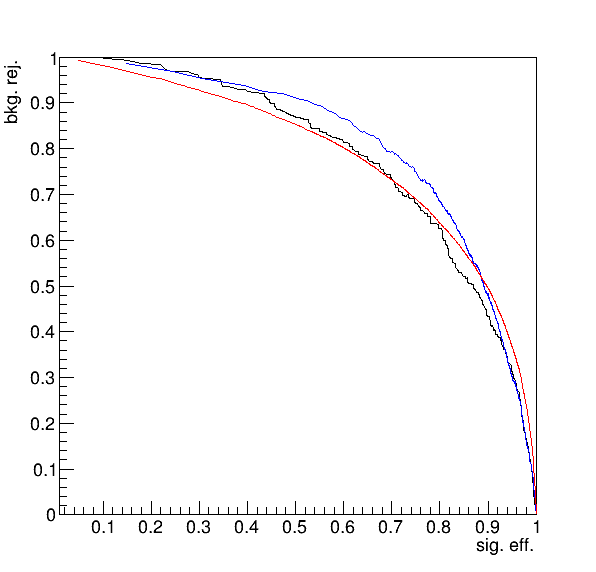

In [5]:
roc_nonprompt.GetXaxis().SetRangeUser(0., 1.); roc_nonprompt.GetXaxis().SetTitle("sig. eff.")
roc_nonprompt.GetYaxis().SetRangeUser(0., 1.); roc_nonprompt.GetYaxis().SetTitle("bkg. rej.")

roc_nonprompt.SetLineColor(R.kBlack)
roc_diboson.SetLineColor(R.kBlue)
roc_ttX.SetLineColor(R.kRed)

c = R.TCanvas("c", "", 600, 600)
#c.SetLogy()
c.cd()
roc_nonprompt.Draw()
roc_diboson.Draw("same")
roc_ttX.Draw("same")
c.Draw()

In [6]:
# estimate with total backgrounds
h_sig = getScoreDistribution(SIGNAL, target="nonprompt")
h_nonprompt = None
for bkg in backgrounds:
    h = getScoreDistribution(bkg, target="nonprompt")
    if h_nonprompt is None:
        h_nonprompt = h.Clone("score_bkg_nonprompt")
    else:
        h_nonprompt.Add(h)

roc_nonprompt = R.TGraph()
for bin in range(1, h_sig.GetNbinsX()+1):
    sig_eff = h_sig.Integral(bin, 1000) / h_sig.Integral(0, 1000)
    bkg_rej = 1. - h_nonprompt.Integral(bin, 1000) / h_nonprompt.Integral(0, 1000)
    roc_nonprompt.AddPoint(sig_eff, bkg_rej)

h_sig = getScoreDistribution(SIGNAL, target="diboson")
h_diboson = None
for bkg in backgrounds:
    h = getScoreDistribution(bkg, target="diboson")
    if h_diboson is None:
        h_diboson = h.Clone("score_bkg_diboson")
    else:
        h_diboson.Add(h)

roc_diboson = R.TGraph()
for bin in range(1, h_sig.GetNbinsX()+1):
    sig_eff = h_sig.Integral(bin, 1000) / h_sig.Integral(0, 1000)
    bkg_rej = 1. - h_VV.Integral(bin, 1000) / h_VV.Integral(0, 1000)
    roc_diboson.AddPoint(sig_eff, bkg_rej)
    
h_sig = getScoreDistribution(SIGNAL, target="ttZ")
h_ttZ = None
for bkg in backgrounds:
    h = getScoreDistribution(bkg, target="ttZ")
    if h_ttZ is None:
        h_ttZ = h.Clone("score_bkg_ttZ")
    else:
        h_ttZ.Add(h)
        
roc_ttZ = R.TGraph()
for bin in range(1, h_sig.GetNbinsX()+1):
    sig_eff = h_sig.Integral(bin, 1000) / h_sig.Integral(0, 1000)
    bkg_rej = 1. - h_ttZ.Integral(bin, 1000) / h_ttZ.Integral(0, 1000)
    roc_ttZ.AddPoint(sig_eff, bkg_rej)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


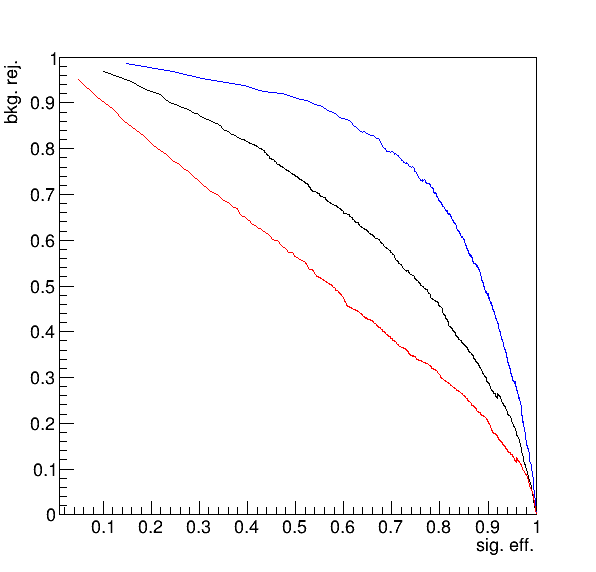

In [7]:
roc_nonprompt.GetXaxis().SetRangeUser(0., 1.); roc_nonprompt.GetXaxis().SetTitle("sig. eff.")
roc_nonprompt.GetYaxis().SetRangeUser(0., 1.); roc_nonprompt.GetYaxis().SetTitle("bkg. rej.")

roc_nonprompt.SetLineColor(R.kBlack)
roc_diboson.SetLineColor(R.kBlue)
roc_ttZ.SetLineColor(R.kRed)

c = R.TCanvas("c", "", 600, 600)
#c.SetLogy()
c.cd()
roc_nonprompt.Draw()
roc_diboson.Draw("same")
roc_ttZ.Draw("same")
c.Draw()